In [128]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [129]:
# Loading data from five csv files:

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
members = pd.read_csv('members.csv')
songs = pd.read_csv('songs.csv')
songs_x = pd.read_csv('song_extra_info.csv')

In [130]:
# #creating feature table of all files

F_table =[["train.csv", len(train.columns)],
          ["songs.csv", len(songs.columns)],
          ["song_extra_info.csv",len(songs_x.columns) ],
          ["members.csv", len(members.columns)]]
pd.DataFrame(F_table, columns=["Name of the file", "Number of features"])   

,Name of the file,Number of features
0,train.csv,6
1,songs.csv,7
2,song_extra_info.csv,3
3,members.csv,7


In [102]:
#Data merging from songs and songs_x datafrom to train and test data

songs =pd.merge(songs, songs_x, on='song_id')
train=pd.merge(train, songs, on='song_id', how='left')
train=pd.merge(train, members, on='msno', how='left')
test=pd.merge(train, songs, on='song_id', how='left')
test=pd.merge(train, members, on='msno', how='left')

In [103]:
data= [['msno', train['msno'].count()],
['song_id', train['song_id'].count()],
['source_system_tab', train['source_system_tab'].count()],
['source_screen_name', train['source_screen_name'].count()],
['source_type', train['msno'].count()],
['target', train['source_type'].count()],
['song_length', train['song_length'].count()],
['genre_ids', train['genre_ids'].count()],
['artist_name', train['artist_name'].count()],
['composer', train['composer'].count()],
['lyricist', train['lyricist'].count()],
['language', train['language'].count()],
['name', train['name'].count()],
['isrc', train['isrc'].count()],
['city', train['city'].count()],
['bd', train['bd'].count()],
['gender', train['gender'].count()],
['registered_via', train['registered_via'].count()],
['registration_init_time', train['registration_init_time'].count()],
['expiration_date', train['expiration_date'].count()]]
pd.DataFrame(data, columns=["Name of feature", "Total count"]) 

,Name of feature,Total count
0,msno,7377418
1,song_id,7377418
2,source_system_tab,7352569
3,source_screen_name,6962614
4,source_type,7377418
5,target,7355879
6,song_length,7375849
7,genre_ids,7257512
8,artist_name,7375849
9,composer,5700724


In [104]:
#delete unwanted dataframes to avoid redundadncy
del songs 
del songs_x
del members

In [105]:
# Calculating Missing value rate of different features in training data

missing = train.isnull().sum(axis=0).reset_index()
missing.columns = ['column_name', 'missing_count']
missing['filling_factor'] = (train.shape[0]- missing['missing_count']) / train.shape[0] * 100
missing.sort_values('filling_factor').reset_index(drop = True)

,column_name,missing_count,filling_factor
0,lyricist,3179542,56.901697
1,gender,2961479,59.857514
2,composer,1676694,77.272618
3,isrc,577963,92.165782
4,source_screen_name,414804,94.377382
5,genre_ids,119906,98.374689
6,source_system_tab,24849,99.663175
7,source_type,21539,99.708041
8,language,1605,99.978244
9,name,1571,99.978705


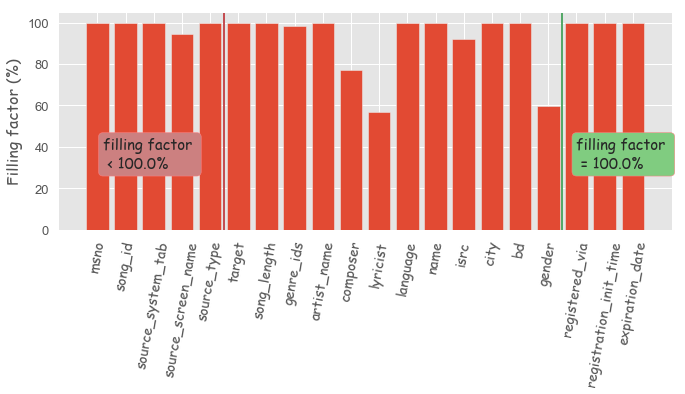

In [106]:
#Plotting Missing value rate of different features in training data

y_axis = missing['filling_factor'] 
x_label = missing['column_name']
x_axis = missing.index

fig = plt.figure(figsize=(11, 4))
plt.xticks(rotation=80, fontsize = 14)
plt.yticks(fontsize = 13)

N_thresh = 5
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'r')
plt.text(N_thresh-4.8, 30, 'filling factor \n < {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'fantasy', bbox=dict(boxstyle="round",
                   ec=(1.0, 0.5, 0.5),
                   fc=(0.8, 0.5, 0.5)))
N_thresh = 17
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'g')
plt.text(N_thresh, 30, 'filling factor \n = {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'fantasy', bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(0.5, 0.8, 0.5)))

plt.xticks(x_axis, x_label,family='fantasy', fontsize = 14 )
plt.ylabel('Filling factor (%)', family='fantasy', fontsize = 16)
plt.bar(x_axis, y_axis);

In [107]:
# Replacing 'NA' with 'unkown'

for i in train.select_dtypes(include=['object']).columns:
    train[i][train[i].isnull()] = 'unknown'
train = train.fillna(value=0)

In [108]:
# converting registration & expiration dates in traing data in yyyy/mm/dd format: 

#Registration_date
train.registration_init_time = pd.to_datetime(train.registration_init_time, format='%Y%m%d', errors='ignore')

# expiration_date
train.expiration_date = pd.to_datetime(train.expiration_date,  format='%Y%m%d', errors='ignore')

In [109]:
#Feature extraction
# Seperating year, month and day from registration & expiration dates for user
from astropy.table import Table, Column
Feature_table=Table()

#Registration_date
Feature_table['F_registration_year'] = train['registration_init_time'].dt.year
Feature_table['F_registration_month'] = train['registration_init_time'].dt.month
Feature_table['F_registration_day'] = train['registration_init_time'].dt.day


# expiration_date
Feature_table['F_expiration_year'] = train['expiration_date'].dt.year
Feature_table['F_expiration_month'] = train['expiration_date'].dt.month
Feature_table['F_expiration_day'] = train['expiration_date'].dt.day

In [110]:
# Dates to category

train['registration_init_time'] = train['registration_init_time'].astype('category')
train['expiration_date'] = train['expiration_date'].astype('category')


In [111]:
# Object data to category
for col in train.select_dtypes(include=['object']).columns:
    train[col] = train[col].astype('category')
    
# Encoding categorical features
for col in train.select_dtypes(include=['category']).columns:
    train[col] = train[col].cat.codes

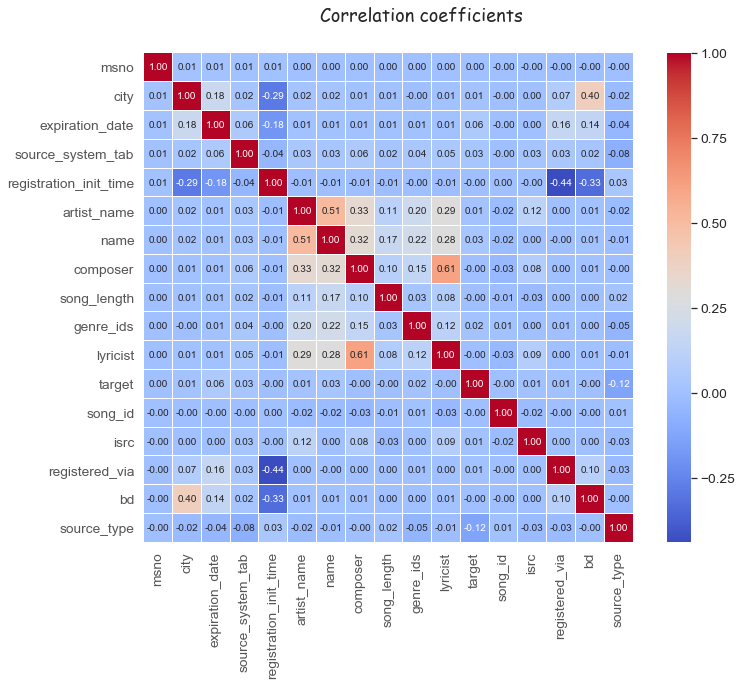

In [112]:
# Сorrelation matrix


f, ax = plt.subplots(figsize=(12, 9))
#_____________________________
# calculations of correlations
corrmat = train.dropna(how='any').corr()
#________________________________________
k = 17 # number of variables for heatmap

cols = corrmat.nlargest(k, 'msno')['msno'].index
cm = np.corrcoef(train[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Correlation matrix", ha='center', fontsize = 18, family='fantasy')
plt.show()

In [113]:
train['source_system_tab'].value_counts()

3    3684730
0    2179252
6     623286
5     476701
2     212266
1     167949
8      24849
4       6185
7       2200
Name: source_system_tab, dtype: int64

In [114]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan

In [115]:
Feature_table['F_song_year'] = train['isrc'].apply(isrc_to_year)

In [116]:
# 1% sample of items
train = train.sample(frac=0.1)

In [117]:
# Drop columns
train = train.drop(['expiration_date', 'lyricist'], 1)

In [118]:
# Model with the best estimator
model = RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(train[train.columns[train.columns != 'target']], train.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [119]:
df_plot = pd.DataFrame({'features': train.columns[train.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

print (model.feature_importances_)

[0.11368095 0.07381585 0.04128936 0.05525838 0.06944498 0.07594158
 0.02774731 0.0633912  0.05983315 0.01217831 0.07390596 0.0722064
 0.04655625 0.05685436 0.0190626  0.02486351 0.11396986]


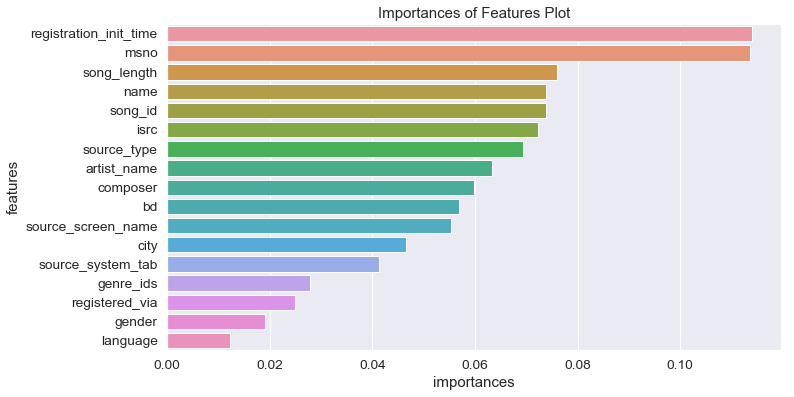

In [120]:
plt.figure(figsize=[11,6])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [121]:
# Drop columns with importances < 0.04
train = train.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [122]:
# Selected columns
train.columns

Index([u'msno', u'song_id', u'source_system_tab', u'source_screen_name',
       u'source_type', u'target', u'song_length', u'artist_name', u'composer',
       u'name', u'isrc', u'city', u'bd', u'registration_init_time'],
      dtype='object')

In [123]:
# Train & Test split
from sklearn.model_selection import train_test_split
target = train.pop('target')
train_data, test_data, train_labels, test_labels = train_test_split(train, target, test_size = 0.3)

# Delete df
#del df

In [124]:
# Create model
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=250)
model.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=15, min_child_weight=5, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [125]:
# Predicting
predict_labels = model.predict(test_data)

In [126]:
print(metrics.classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

           0       0.67      0.63      0.65    109762
           1       0.66      0.69      0.68    111561

   micro avg       0.66      0.66      0.66    221323
   macro avg       0.66      0.66      0.66    221323
weighted avg       0.66      0.66      0.66    221323



In [98]:
del train

NameError: name 'train' is not defined

In [127]:
Feature_table.info()

<Table length=7377418>
        name          dtype   n_bad 
-------------------- ------- -------
 F_registration_year   int64       0
F_registration_month   int64       0
  F_registration_day   int64       0
   F_expiration_year   int64       0
  F_expiration_month   int64       0
    F_expiration_day   int64       0
         F_song_year float64 7377418
